# Bitcoin Attention LSTM

## 1. Setup & Imports

In [497]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam, RMSprop, SGD


SEED = 42 # for reproducibility
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


plt.rcParams['figure.figsize'] = (10,6)
sns.set(style='whitegrid')

In [498]:
df = pd.read_excel("data.xlsx")
df.head()

,date,crude oil ( WTI),Heating Oil,Conventional Gasoline,RBOB,Ultra-Low Sulfur CARB Diesel,Kerosene-Type Jet Fuel,Propane,Natural GAZ,DJIA,NASDAQ,sp500,bitcoin,USD FUTURE INDEX,gold,Silver,copper
0,2015-01-02,52.72,1.554,1.378,1.586,1.537,1.539,0.546,2.889,"17,501.65","4,726.81","2,058.20","8,726.2",99.596,"1,184.80",15.829,2.9295
1,2015-01-05,50.05,1.646,1.462,1.667,1.518,1.647,0.547,2.894,"17,371.64","4,652.57","2,020.60","8,916.8",99.768,"1,188.15",15.636,2.9205
2,2015-01-06,47.98,1.709,1.540,1.750,1.516,1.709,0.574,2.855,"17,584.52","4,592.74","2,002.60","8,547.4",98.940,"1,184.20",16.394,2.9350
3,2015-01-07,48.69,1.774,1.575,1.663,1.599,1.653,0.594,2.777,"17,907.87","4,650.47","2,025.90","8,473.2",98.525,"1,193.50",16.591,2.9260
4,2015-01-08,48.80,1.718,1.483,1.659,1.674,1.675,0.604,2.816,"17,737.37","4,736.19","2,062.10","8,143.5",97.614,"1,215.73",16.702,2.9180


In [499]:
df.columns = [c.strip().lower() for c in df.columns]
raw = df.rename(columns={col: col.replace(' ', '_') for col in df.columns})
df.columns.tolist()

['date',
 'crude oil ( wti)',
 'heating oil',
 'conventional gasoline',
 'rbob',
 'ultra-low sulfur carb diesel',
 'kerosene-type jet fuel',
 'propane',
 'natural gaz',
 'djia',
 'nasdaq',
 'sp500',
 'bitcoin',
 'usd future index',
 'gold',
 'silver',
 'copper']

In [500]:
df.dtypes

date                            datetime64[ns]
crude oil ( wti)                       float64
heating oil                            float64
conventional gasoline                  float64
rbob                                   float64
ultra-low sulfur carb diesel           float64
kerosene-type jet fuel                 float64
propane                                float64
natural gaz                            float64
djia                                    object
nasdaq                                  object
sp500                                   object
bitcoin                                 object
usd future index                       float64
gold                                    object
silver                                 float64
copper                                 float64
dtype: object

In [501]:
df = df.sort_values('date').set_index('date')
df = df.replace(',', '', regex=True).apply(pd.to_numeric, errors='coerce')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2569 entries, 2015-01-02 to 2024-12-31
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   crude oil ( wti)              2505 non-null   float64
 1   heating oil                   2569 non-null   float64
 2   conventional gasoline         2569 non-null   float64
 3   rbob                          2568 non-null   float64
 4   ultra-low sulfur carb diesel  2564 non-null   float64
 5   kerosene-type jet fuel        2568 non-null   float64
 6   propane                       2562 non-null   float64
 7   natural gaz                   2516 non-null   float64
 8   djia                          2516 non-null   float64
 9   nasdaq                        2516 non-null   float64
 10  sp500                         2516 non-null   float64
 11  bitcoin                       2516 non-null   float64
 12  usd future index              2516 non-null 

,crude oil ( wti),heating oil,conventional gasoline,rbob,ultra-low sulfur carb diesel,kerosene-type jet fuel,propane,natural gaz,djia,nasdaq,sp500,bitcoin,usd future index,gold,silver,copper
date,,,,,,,,,,,,,,,,
2015-01-02,52.72,1.554,1.378,1.586,1.537,1.539,0.546,2.889,17501.65,4726.81,2058.2,8726.2,99.596,1184.80,15.829,2.9295
2015-01-05,50.05,1.646,1.462,1.667,1.518,1.647,0.547,2.894,17371.64,4652.57,2020.6,8916.8,99.768,1188.15,15.636,2.9205
2015-01-06,47.98,1.709,1.540,1.750,1.516,1.709,0.574,2.855,17584.52,4592.74,2002.6,8547.4,98.940,1184.20,16.394,2.9350
2015-01-07,48.69,1.774,1.575,1.663,1.599,1.653,0.594,2.777,17907.87,4650.47,2025.9,8473.2,98.525,1193.50,16.591,2.9260
2015-01-08,48.80,1.718,1.483,1.659,1.674,1.675,0.604,2.816,17737.37,4736.19,2062.1,8143.5,97.614,1215.73,16.702,2.9180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,70.87,2.011,1.901,2.301,2.208,1.909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-26,70.38,1.929,1.873,2.286,2.205,1.886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-12-27,71.28,1.906,1.874,2.287,2.138,1.887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [502]:
print(df.shape)
df.isnull().sum()

(2569, 16)


crude oil ( wti)                64
heating oil                      0
conventional gasoline            0
rbob                             1
ultra-low sulfur carb diesel     5
kerosene-type jet fuel           1
propane                          7
natural gaz                     53
djia                            53
nasdaq                          53
sp500                           53
bitcoin                         53
usd future index                53
gold                            53
silver                          53
copper                          53
dtype: int64

In [503]:
df = df.ffill().bfill() #forward fill and backward fill
# If there are still NaNs, drop rows where > 30% of features are NaN
thresh = int(df.shape[1] * 0.7)
df = df.dropna(thresh=thresh)
print('shape after cleaning:', df.shape)
df.isnull().sum()

shape after cleaning: (2569, 16)


crude oil ( wti)                0
heating oil                     0
conventional gasoline           0
rbob                            0
ultra-low sulfur carb diesel    0
kerosene-type jet fuel          0
propane                         0
natural gaz                     0
djia                            0
nasdaq                          0
sp500                           0
bitcoin                         0
usd future index                0
gold                            0
silver                          0
copper                          0
dtype: int64

## EDA (QUICK)

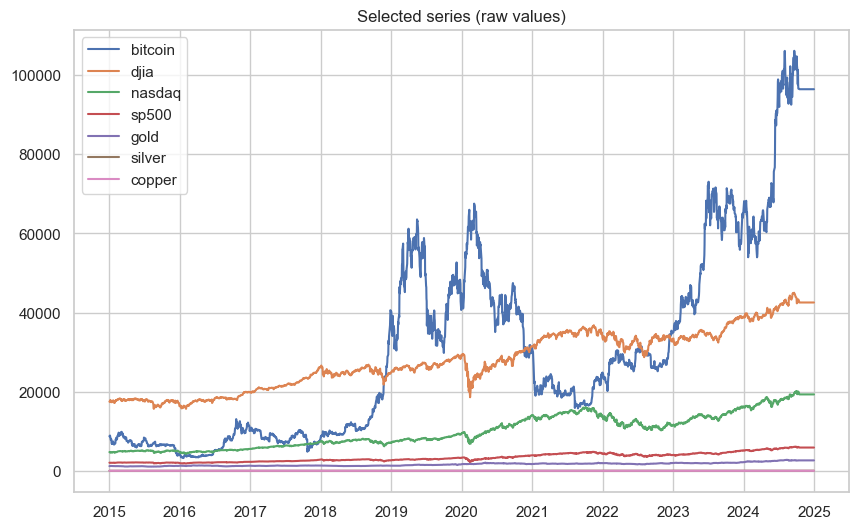

In [504]:
selected = ['bitcoin', 'crude_oil_(wti)', 'natural_gaz', 'djia', 'nasdaq', 'sp500', 'gold', 'silver', 'copper']
selected = [c for c in selected if c in df.columns]


for col in selected:
    plt.plot(df.index, df[col], label=col)
plt.legend()
plt.title('Selected series (raw values)')
plt.show()

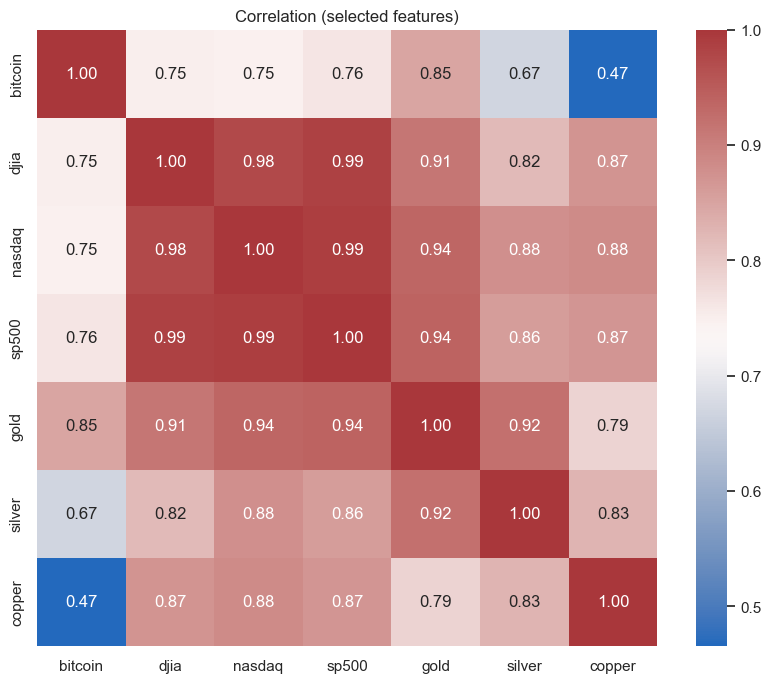

In [505]:
corr = df[selected].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation (selected features)')
plt.show()

## Feature Engineering

In [506]:
TARGET = 'bitcoin'
FEATURES = [c for c in df.columns if c != TARGET]


# pick top predictors by absolute correlation with target (simple heuristic)
corr_with_target = df[FEATURES + [TARGET]].corr()[TARGET].abs().sort_values(ascending=False)
print(corr_with_target.head(12))


# choose top K
K = 5
top_feats = [f for f in corr_with_target.index if f != TARGET][:K]
print('top features:', top_feats)


window_lags = [1,2,3,5,7]
rolling_windows = [3,7,14]


feat_df = df[[TARGET] + top_feats].copy()


# add lags for target
for lag in window_lags:
    feat_df[f'{TARGET}_lag_{lag}'] = feat_df[TARGET].shift(lag)


# add rolling means & std for target and top features
for w in rolling_windows:
    feat_df[f'{TARGET}_rm_{w}'] = feat_df[TARGET].rolling(w).mean()
    feat_df[f'{TARGET}_rstd_{w}'] = feat_df[TARGET].rolling(w).std()
    for f in top_feats:
        feat_df[f'{f}_rm_{w}'] = feat_df[f].rolling(w).mean()


# drop rows with NaNs created by lagging
feat_df = feat_df.dropna()
print('feature matrix shape:', feat_df.shape)

bitcoin                         1.000000
gold                            0.847993
sp500                           0.763197
djia                            0.750251
nasdaq                          0.745749
silver                          0.669935
usd future index                0.542945
copper                          0.465835
crude oil ( wti)                0.322578
ultra-low sulfur carb diesel    0.242440
kerosene-type jet fuel          0.214515
heating oil                     0.210042
Name: bitcoin, dtype: float64
top features: ['gold', 'sp500', 'djia', 'nasdaq', 'silver']
feature matrix shape: (2556, 32)


In [507]:
feat_df['bitcoin'] = np.log1p(feat_df['bitcoin'])

## Train/Validation/Test split & scaling

In [508]:
TEST_SIZE = 0.15
VAL_SIZE = 0.10


n = len(feat_df)
idx_test = int(n * (1 - TEST_SIZE))
idx_val = int(idx_test * (1 - VAL_SIZE/(1-TEST_SIZE)))


train_df = feat_df.iloc[:idx_val]
val_df = feat_df.iloc[idx_val:idx_test]
test_df = feat_df.iloc[idx_test:]


print('train/val/test sizes:', len(train_df), len(val_df), len(test_df))


# scaling
scaler = MinMaxScaler()
X_train = train_df.drop(columns=[TARGET]).values
X_val = val_df.drop(columns=[TARGET]).values
X_test = test_df.drop(columns=[TARGET]).values


y_train = train_df[TARGET].values.reshape(-1,1)
y_val = val_df[TARGET].values.reshape(-1,1)
y_test = test_df[TARGET].values.reshape(-1,1)


scaler_X = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train)


X_train_s = scaler_X.transform(X_train)
X_val_s = scaler_X.transform(X_val)
X_test_s = scaler_X.transform(X_test)


y_train_s = scaler_y.transform(y_train)
y_val_s = scaler_y.transform(y_val)
y_test_s = scaler_y.transform(y_test)


# keep column names for later
feature_cols = train_df.drop(columns=[TARGET]).columns.tolist()
print('n_features:', len(feature_cols))

train/val/test sizes: 1916 256 384
n_features: 31


## Sequence creation (for LSTM)

In [509]:
def create_sequences(X, y, n_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - n_steps):
        Xs.append(X[i:i+n_steps])
        ys.append(y[i + n_steps])
    return np.array(Xs), np.array(ys)


N_STEPS = 5


Xtr, ytr = create_sequences(X_train_s, y_train_s, N_STEPS)
Xv, yv = create_sequences(X_val_s, y_val_s, N_STEPS)
Xt, yt = create_sequences(X_test_s, y_test_s, N_STEPS)


print('Xtr shape:', Xtr.shape, 'ytr shape:', ytr.shape)

Xtr shape: (1911, 5, 31) ytr shape: (1911, 1)


## LSTM + Attention model (Keras)

In [510]:
from tensorflow.keras.layers import Layer


class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        # input_shape: (batch, time, features)
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1],), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)


    def call(self, inputs):
        # score: dot product between inputs and W -> (batch, time)
        score = tf.tensordot(inputs, self.W, axes=[2,0])
        weights = tf.nn.softmax(score, axis=1)
        weights = tf.expand_dims(weights, axis=-1) # (batch, time, 1)
        weighted = inputs * weights
        context = tf.reduce_sum(weighted, axis=1) # (batch, features)
        return context, weights




def build_lstm_attention(n_steps, n_features, units=32, dropout=0.2):
    inp = layers.Input(shape=(n_steps, n_features))
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(inp)
    x = layers.Dropout(dropout)(x)
    context, att_weights = AttentionLayer()(x)
    out = layers.Dense(1)(context)
    model = models.Model(inputs=inp, outputs=[out, att_weights])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss='mse')
    return model


n_features = Xtr.shape[2]
model = build_lstm_attention(N_STEPS, n_features, units=32, dropout=0.2)
model.summary()

Model: "functional_359"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_180 (InputLayer)    │ (None, 5, 31)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_180               │ (None, 5, 64)          │        16,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_180             │ [(None, 64), (None, 5, │            64 │
│ (AttentionLayer)                │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 0 (0.00 B)

#### optimizer

In [511]:
pred_model = models.Model(inputs=model.input, outputs=model.output[0])
pred_model.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')
pred_model.summary()

Model: "functional_360"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_180 (InputLayer)    │ (None, 5, 31)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_180               │ (None, 5, 64)          │        16,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_180 (Dropout)           │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_180             │ [(None, 64), (None, 5, │            64 │
│ (AttentionLayer)                │ 1)]                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_180 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,513 (64.50 KB)

 Trainable params: 16,513 (64.50 KB)

 Non-trainable params: 0 (0.00 B)

In [512]:
# pred_model = models.Model(inputs=model.input, outputs=model.output[0])
# pred_model.compile(optimizer=RMSprop(learning_rate=1e-3), loss='mse')
# pred_model.summary()

In [513]:
# pred_model = models.Model(inputs=model.input, outputs=model.output[0])
# pred_model.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='mse')
# pred_model.summary()

## Training

Epoch 1/100


60/60 - 8s - 138ms/step - loss: 0.0236 - val_loss: 9.5142e-04
Epoch 2/100
60/60 - 1s - 11ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 3/100


60/60 - 1s - 13ms/step - loss: 0.0056 - val_loss: 3.5252e-04
Epoch 4/100
60/60 - 1s - 23ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 5/100
60/60 - 1s - 12ms/step - loss: 0.0044 - val_loss: 0.0020
Epoch 6/100
60/60 - 1s - 12ms/step - loss: 0.0039 - val_loss: 9.8163e-04
Epoch 7/100
60/60 - 1s - 11ms/step - loss: 0.0035 - val_loss: 6.6565e-04
Epoch 8/100
60/60 - 1s - 11ms/step - loss: 0.0031 - val_loss: 4.5518e-04
Epoch 9/100
60/60 - 1s - 11ms/step - loss: 0.0028 - val_loss: 8.4720e-04
Epoch 10/100
60/60 - 1s - 21ms/step - loss: 0.0024 - val_loss: 6.5382e-04
Epoch 11/100
60/60 - 0s - 6ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 12/100
60/60 - 0s - 7ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 13/100
60/60 - 1s - 11ms/step - loss: 0.0020 - val_loss: 9.2875e-04


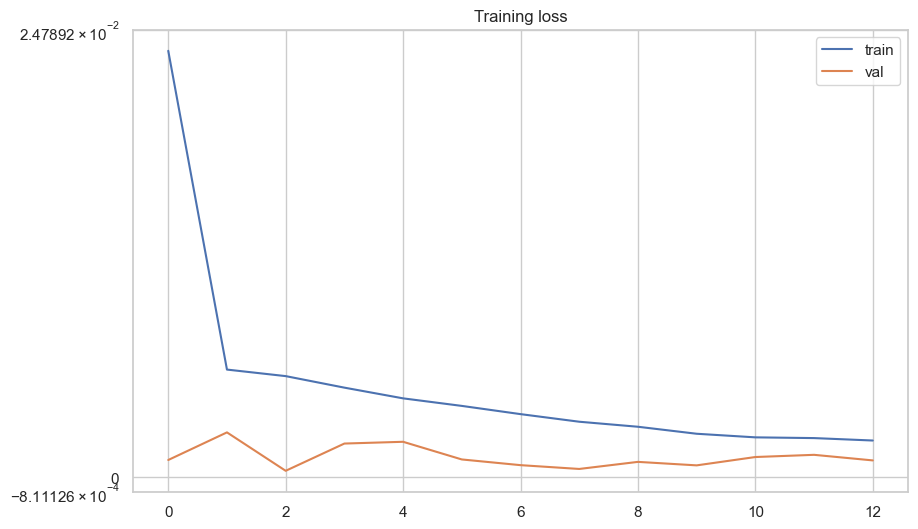

In [514]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ck = callbacks.ModelCheckpoint('best_lstm_attn.h5', save_best_only=True, monitor='val_loss')


history = pred_model.fit(
Xtr, ytr,
validation_data=(Xv, yv),
epochs=100,
batch_size=32,
callbacks=[es, ck],
verbose=2
)


# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.yscale('symlog')
plt.legend()
plt.title('Training loss')
plt.show()

## Evaluation on test set

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Test RMSE: 6593.849674099984
Test MAE: 5354.324470234165
Test R2: 0.8407667025794493


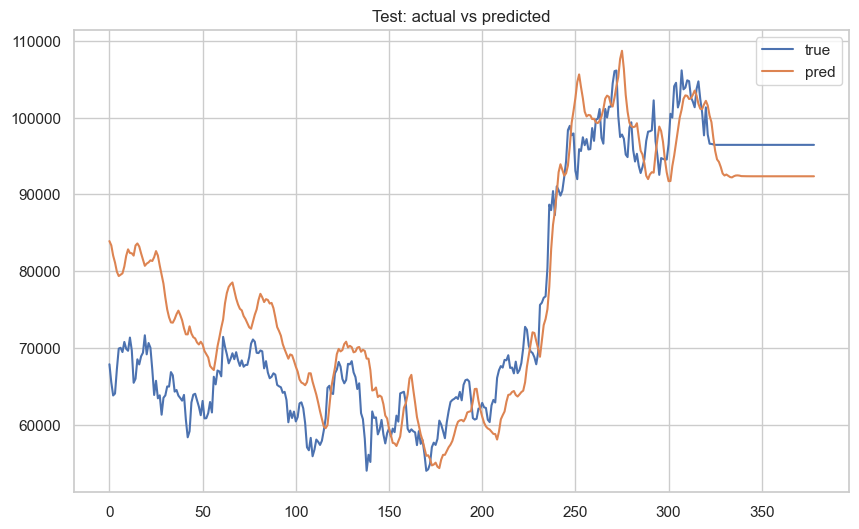

In [515]:
# load best model
pred_model.load_weights('best_lstm_attn.h5')


# get predictions
y_pred_s = pred_model.predict(Xt)


y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
y_true = scaler_y.inverse_transform(yt.reshape(-1,1)).ravel()


# invert log1p to get actual prices
y_pred = np.expm1(y_pred)
y_true = np.expm1(y_true)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print('Test RMSE:', rmse)
print('Test MAE:', mae)
print('Test R2:', r2)


# plot actual vs predicted
plt.plot(y_true, label='true')
plt.plot(y_pred, label='pred')
plt.legend()
plt.title('Test: actual vs predicted')
plt.show()

## Extract & visualize attention weights

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


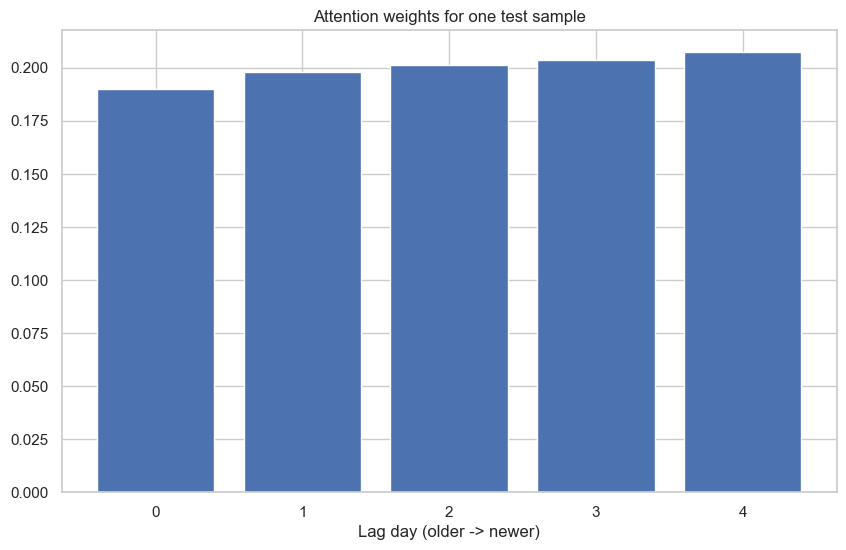

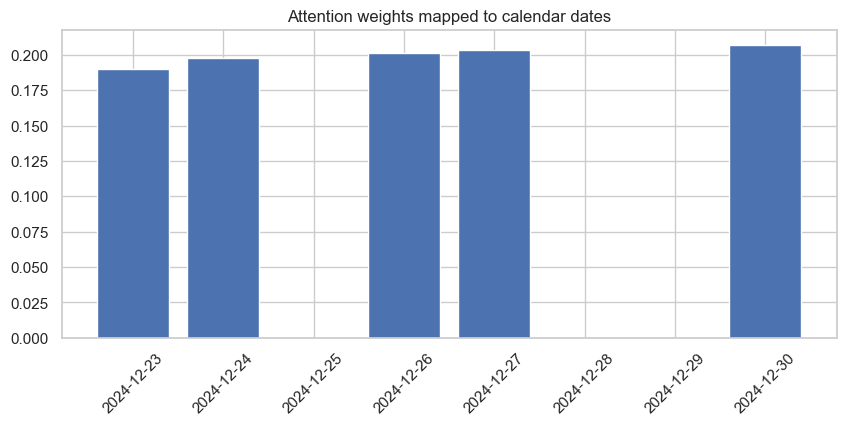

In [516]:
# Use the original full model which outputs [pred, att_weights]
full_model = model


# run predictions on Xt to retrieve attention
preds, att_weights = full_model.predict(Xt)
# att_weights shape: (samples, time, 1)
att_weights = np.squeeze(att_weights, axis=-1)


# pick a sample index to visualize (e.g., the last test sample)
idx = -1
sample_weights = att_weights[idx]
plt.bar(range(N_STEPS), sample_weights)
plt.xlabel('Lag day (older -> newer)')
plt.title('Attention weights for one test sample')
plt.show()


# Map attention to actual calendar dates for interpretability
seq_dates_test = feat_df.index[-len(yt):]
sample_dates = seq_dates_test[idx-N_STEPS:idx]
plt.figure(figsize=(10,4))
plt.bar(sample_dates, sample_weights)
plt.xticks(rotation=45)
plt.title('Attention weights mapped to calendar dates')
plt.show()

In [517]:
# from sklearn.utils import shuffle
# import itertools

# # Define search space
# param_grid = {
#     'units': [32, 64, 128],
#     'dropout': [0.1, 0.2, 0.3],
#     'learning_rate': [1e-4, 5e-4, 1e-3],
#     'batch_size': [16, 32, 64]
# }

# # Generate all combinations
# all_params = list(itertools.product(param_grid['units'], param_grid['dropout'], 
#                                     param_grid['learning_rate'], param_grid['batch_size']))

# best_rmse = float('inf')
# best_params = None

# for i, (units, dropout, lr, batch_size) in enumerate(all_params):
#     print(f"Testing params {i+1}/{len(all_params)}: units={units}, dropout={dropout}, lr={lr}, batch_size={batch_size}")
    
#     # Build & compile model
#     model = build_lstm_attention(N_STEPS, n_features, units=units, dropout=dropout)
#     pred_model = models.Model(inputs=model.input, outputs=model.output[0])
#     pred_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    
#     # Fit model
#     history = pred_model.fit(
#         Xtr, ytr,
#         validation_data=(Xv, yv),
#         epochs=50,
#         batch_size=batch_size,
#         verbose=0,
#         callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
#     )
    
#     # Predict on validation set
#     yv_pred = pred_model.predict(Xv)
#     yv_true = yv
    
#     # Inverse scale
#     yv_pred = scaler_y.inverse_transform(yv_pred)
#     yv_true = scaler_y.inverse_transform(yv_true)
    
#     rmse_val = np.sqrt(mean_squared_error(yv_true, yv_pred))
#     print("RMSE:", rmse_val)
    
#     if rmse_val < best_rmse:
#         best_rmse = rmse_val
#         best_params = {'units': units, 'dropout': dropout, 'learning_rate': lr, 'batch_size': batch_size}

# print('Best params from search:', best_params, 'with RMSE:', best_rmse)

# # Optionally: retrain final model on train+val using best_params before testing
# X_final = np.concatenate([Xtr, Xv], axis=0)
# y_final = np.concatenate([ytr, yv], axis=0)

# final_model = build_lstm_attention(N_STEPS, n_features, units=best_params['units'], dropout=best_params['dropout'])
# final_pred_model = models.Model(inputs=final_model.input, outputs=final_model.output[0])
# final_pred_model.compile(optimizer=tf.keras.optimizers.Adam(best_params['learning_rate']), loss='mse')

# final_pred_model.fit(
#     X_final, y_final,
#     epochs=100,
#     batch_size=best_params['batch_size'],
#     verbose=2,
#     callbacks=[callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
# )
